In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as sl
from scipy.integrate import trapz, cumtrapz
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
sns.set_context('talk')

README
===

Only track $x$ coordinate

In [3]:
#  kappa reference
k_data = np.loadtxt('k.dat.bz2')
kt = k_data[:, 0]
kT = k_data[:, 1]
kJ = k_data[:, 2]
kK = k_data[:, 5]

kappa_df = pd.DataFrame({'k': kK, 'temp': kT}, index=kt)

In [4]:
data = np.loadtxt('j.dat.bz2')

def get_corr(data, step=10, nmax=100000, window=True):
    """return correlation function as pd.Series"""
    time = data[:nmax:step, 0]
    temp = data[:nmax:step, 1]

    # restore extensive flux
    J = data[:nmax:step, 2] * vol

    Nt = len(J)
    
    corr = sl.correlate(J, J)[Nt - 1 :]
    
    # Normalize
    corr /= np.arange(Nt, 0, -1)
    if window:  # window
        corr *= sl.windows.hann(2 * Nt)[Nt:]
    
    return pd.Series(corr, index=time)

In [5]:
def exp(x, y0, tau):
    return y0 * np.exp( - x / tau)


def F_avalanche(series, delta='auto', verbose=True):
    """Compute Avalanche Function (windowed noise/signal ratio)"""
    
    if delta == 'auto':
        # estimate correlation time
        
        exp = lambda x, y0, tau: y0 * np.exp( - x / tau)
        
        # where is jc drops below 1/e the first time
        idx = series[series < series.max() / np.e].index[0]
        x = series[:idx]
        (y0, tau), _ = curve_fit(exp, x.index, x)
    
        delta = len(series[series.index < tau])
        
        assert 0.5 < idx / tau < 2, (idx, tau)
        
        if verbose:
            print(f'Pre-est. correlation time (drop below 1/e): {idx:10.2f} fs')
            print(f'.. estimated correlation time:              {tau:10.2f} fs')
            print(f'-> choose delta of size: {delta:20d} data points')

    
    sigma = series.rolling(window=delta, min_periods=0).std()
    E = series.rolling(window=delta, min_periods=0).mean()
    
    F = (sigma / E).abs().dropna()

    return F

def t_avalanche(series, Fmax=1, verbose=True, **kwargs):
    """get avalanche time for series from F_avalanche"""
    F = F_avalanche(series, verbose=verbose, **kwargs)
    
    tmax = F[F > Fmax].index[0]
    
    if verbose:
        print(f'-> avalanche time with max. F of {Fmax:2d}: {tmax:17.2f} fs')
    
    return tmax

In [6]:
vol = 9943.92
scale = 28.7289125255705

(90.0,
 array([7.25751032e-04, 8.88350738e+01]),
 array([[ 1.10635813e-10, -2.35047807e-05],
        [-2.35047807e-05,  9.18010769e+00]]))

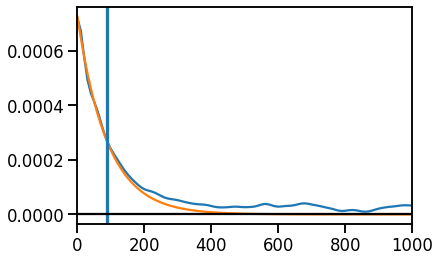

In [7]:
jc = get_corr(data)

# where is jc drops below 1/e the first time
idx = jc[jc < jc.max() / np.e].index[0]

j = jc[:1000]
j_fit = jc[:idx+1]
p, d = curve_fit(exp, j_fit.index, j_fit)

ax = j.plot()
plt.plot(np.asarray(j.index), np.asarray(exp(j.index, *p)))

ax.axvline(p[1])
ax.axvline(idx)
ax.axhline(0, color='k')

idx, p, d

Pre-est. correlation time (drop below 1/e):      90.00 fs
.. estimated correlation time:                   88.84 fs
-> choose delta of size:                    9 data points
-> avalanche time with max. F of  1:           1380.00 fs


(0, 5)

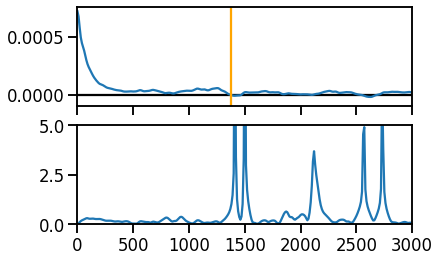

In [8]:
# full correlation function
jc = get_corr(data)
F = F_avalanche(jc, verbose=False)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.axhline(0, color='k')

jc.plot(ax=ax1)
F.plot(ax=ax2)

ax1.axvline(t_avalanche(jc), color='orange')

ax2.set_xlim([0, 3000])
ax2.set_ylim([0, 5])

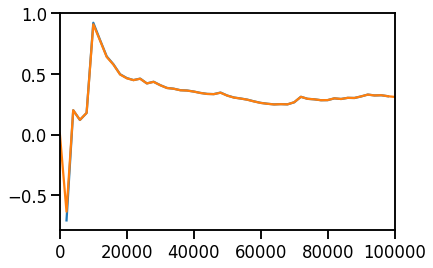

In [9]:
# compare to lammps verbatim

time = np.arange(2000, 100000, 2000)

step = 10
tmax = 2000

k = []
for nmax in time:
    corr = get_corr(data, step=step, nmax=nmax, window=False)[:]
    k.append(trapz(corr[:tmax]) * scale / 10 * step )
    
df = pd.DataFrame({'k': k}, index=time)

ax = df.k.plot()
kappa_df.k.plot(ax=ax)

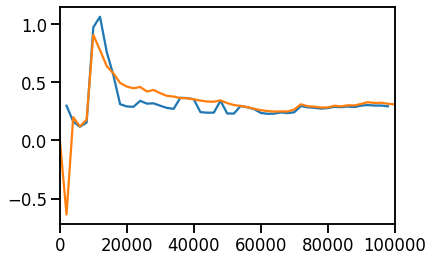

In [10]:
# using windowing and F avalanche

time = np.arange(2000, 100000, 2000)

step = 10

k = []
for nmax in time:
    corr = get_corr(data, step=step, nmax=nmax)
    tmax = t_avalanche(corr, verbose=False)
    k.append(trapz(corr[:tmax]) * scale / 10 * step )
    
df = pd.DataFrame({'k': k}, index=time)

ax = df.k.plot()
kappa_df.k.plot(ax=ax)

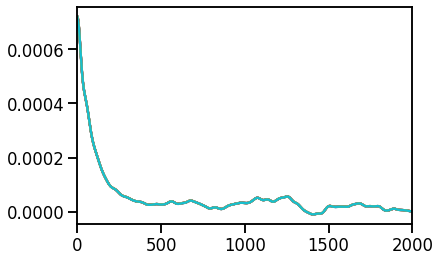

In [11]:
nmax = 2000

c = get_corr(data)[:nmax]

ax = c.plot()

for step in range(1, 10):
    get_corr(data, step=step)[:nmax].plot(ax=ax)